* basic roberta ft: 0.6589791487657798 (thr 0.3)
* basic roberta ft (head first): 0.6768011808573329 (thr 0.42)
* fine tune roberta on weird clf, then only head on spans, then whole: 0.6853127403287083 (thr 0.32)
* 

In [1]:
from transformers import RobertaTokenizer, RobertaForTokenClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
device = torch.device('cuda:0')

In [4]:
model_name = 'roberta-base'  #roberta-base

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# model = AutoModelForTokenClassification.from_pretrained(model_name)

```
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
```

# Create labels for tagging

In [7]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

path = 'data/'

In [63]:
trial = pd.read_csv(path + 'tsd_trial.csv')
train = pd.read_csv(path + 'tsd_train.csv')
# final_test = pd.read_csv(path + 'tsd_test.csv')
final_test = pd.read_csv(path + 'tsd_test_gt.csv')

train['spans'] = train.spans.apply(literal_eval)
trial['spans'] = trial.spans.apply(literal_eval)
final_test['spans'] = final_test.spans.apply(literal_eval)
trial.shape, train.shape, final_test.shape

((690, 2), (7939, 2), (2000, 2))

In [9]:
print(len(set(trial.text).intersection(set(train.text))))
print(len(set(final_test.text).intersection(set(train.text))))

8
0


In [10]:
print((train.spans.apply(len) == 0).mean())
print((trial.spans.apply(len) == 0).mean())

0.06109081748331024
0.06231884057971015


In [11]:
import spans_utils
from importlib import reload
reload(spans_utils)
from spans_utils import display_spans, spans2labels, labels2spans

display_spans(trial.spans[0], trial.text[0])
display_spans(trial.spans[0], trial.text[0])

In [12]:
from tqdm.auto import tqdm, trange

In [15]:
n = 0
for row in tqdm([row for i, row in trial.iterrows()]):
    break
    labels = spans2labels(row.text, row.spans, tokenizer)
    spans2 = labels2spans(row.text, labels, tokenizer)
    if row.spans != spans2:
        t = row.text.replace(' ', '+')
        display_spans(row.spans, t)
        display_spans(spans2, t)
        n += 1
print(n)


0


In [16]:
train_labels = [spans2labels(row.text, row.spans, tokenizer) for i, row in tqdm(train.iterrows())]

In [17]:
trial_labels = [spans2labels(row.text, row.spans, tokenizer) for i, row in tqdm(trial.iterrows())]

In [18]:
train['labels'] = train_labels
trial['labels'] = trial_labels

In [19]:
class SpansDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [20]:
train_dataset = SpansDataset(tokenizer(train.text.tolist()), train_labels)
eval_dataset = SpansDataset(tokenizer(trial.text.tolist()), trial_labels)

In [21]:
final_test_dataset = SpansDataset(tokenizer(final_test.text.tolist()))

In [22]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

In [23]:
import numpy as np
from semeval2021 import f1

### Dataset for classification

In [107]:
import pandas as pd

In [108]:
df1 = pd.read_csv('../data/train/train.1.tsv', sep='\t')
df0 = pd.read_csv('../data/train/train_small.0.tsv', sep='\t')
df01 = pd.concat([df1, df0], ignore_index=True)
df01.label = df01.label.astype(int)
print(df01.shape)
df01.sample(3)

(358984, 2)


,comment_text,label
222509,With Bannon out of the picture he's not nearly...,0
271397,If you want to save 15% on your car insurance ...,0
149303,he sounds like a moron...and to solidify that...,1


In [109]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df01, test_size=0.1, random_state=1)

In [110]:
df_train.head(10)

,comment_text,label
214726,"My Dad had a saying, if you can't play, play l...",0
275434,Awesome! I realize players cannot / will not s...,0
315281,"If it were a school, I'd fire the principal fo...",0
225573,Do you believe POTUS should stop having he and...,0
214259,The Liberals better wake up. \n\nRemember wha...,0
274177,This legislature is violating the Alaska State...,0
20450,if a trip wire or sensors could be hooked up t...,1
182019,See what Dr. Fred Baughman had to say about dr...,0
317139,Impatient millinial. Is that something to adve...,0
23614,"So ridiculous people still call this ""Our oil""...",1


In [111]:
class SpansDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [112]:
clf_train_dataset = SpansDataset(
    tokenizer(df_train.comment_text.tolist(), truncation=True), 
    df_train.label.tolist()
)

In [113]:
clf_test_dataset = SpansDataset(
    tokenizer(df_test.comment_text.tolist(), truncation=True), 
    df_test.label.tolist()
)

In [114]:
clf_test_small_dataset = SpansDataset(
    tokenizer(df_test.comment_text.iloc[:3000].tolist(), truncation=True), 
    df_test.label[:3000].tolist()
)

# Train a single-task model

https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb
https://huggingface.co/transformers/custom_datasets.html

In [35]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.file_utils import cached_property
from typing import Tuple

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self):
        return device

In [36]:
torch.cuda.set_device(device)

In [37]:
model = AutoModelForTokenClassification.from_pretrained(model_name)
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [38]:
for param in model.roberta.parameters():
    param.requires_grad = False

In [42]:
training_args = TrAr(
    output_dir='./models2/roberta_single',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-3,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=100,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [43]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

In [44]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
100,0.869200,0.809791,2.386100,289.170000
200,0.716500,0.603003,2.303700,299.515000
300,0.502000,0.394694,2.192600,314.698000
400,0.353700,0.284466,2.206600,312.698000
500,0.276600,0.248568,2.185200,315.762000
600,0.283500,0.230986,2.258300,305.541000
700,0.284800,0.220532,2.229300,309.510000
800,0.257900,0.213154,2.220600,310.730000
900,0.237000,0.207164,2.245200,307.320000
1000,0.245900,0.203607,2.321700,297.196000


TrainOutput(global_step=3300, training_loss=0.2872040771715569, metrics={'train_runtime': 233.4637, 'train_samples_per_second': 42.533, 'total_flos': 2549211576987996, 'epoch': 3.32})

In [45]:
for param in model.parameters():
    param.requires_grad = True

In [52]:
training_args = TrAr(
    output_dir='./models2/roberta_single',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=500,
    eval_steps=500,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [53]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

* The minimal loss of a single-task model (full) was about 28% on validation with 0.04 on train. 
* If we first train only head (batch 8, lr 1e-3 with 3K warmup and 1e-8 decline), we get minimal loss of 0.185 on validation with 0.23 on train
* Training then the whole model (batch 8, lr 1e-5 with 3K warmup and 1e-8 decline) we get minimal loss of 0.175 on validation with 0.21 on train

In [54]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.214300,0.183102,2.275500,303.228000
1000,0.231800,0.178588,2.282300,302.324000
1500,0.228400,0.178426,2.267800,304.266000
2000,0.219600,0.174098,2.316700,297.833000
2500,0.216500,0.181011,2.336500,295.308000
3000,0.218200,0.181870,2.270400,303.906000
3500,0.206900,0.175007,2.270100,303.947000


TrainOutput(global_step=3500, training_loss=0.2193861323765346, metrics={'train_runtime': 461.8953, 'train_samples_per_second': 21.498, 'total_flos': 2707692614817216, 'epoch': 3.52})

In [68]:
model.save_pretrained('./models2/roberta_single')

In [67]:
trainer.evaluate()

{'eval_loss': 0.17584852874279022}

### evaluate

In [55]:
pred = trainer.predict(eval_dataset)

In [56]:
for threshold in [0, 0.01, 0.03, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 1]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    print(threshold, np.mean([f1(p, y) for p, y in zip(preds, trial.spans)]))

0 0.21345926240649193
0.01 0.2522426276657023
0.03 0.39910998627052807
0.1 0.5959594514495652
0.3 0.6691954194658056
0.4 0.6734060063813712
0.5 0.6728307956631072
0.6 0.652604453261445
0.7 0.6215603361690663
1 0.06231884057971015


In [57]:
for threshold in [0.3, 0.32, 0.35, 0.38, 0.4, 0.42, 0.45, 0.5, 0.55, 0.6]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    print(threshold, np.mean([f1(p, y) for p, y in zip(preds, trial.spans)]))

0.3 0.6691954194658056
0.32 0.6719575974133731
0.35 0.6718814105545576
0.38 0.6704494596966453
0.4 0.6734060063813712
0.42 0.6733924519991911
0.45 0.675073109186953
0.5 0.6728307956631072
0.55 0.6635405099600963
0.6 0.652604453261445


## Prepare a submission

In [59]:
pred = trainer.predict(final_test_dataset)

In [98]:
threshold = 0.4
preds = []
for text, pr in zip(final_test.text, pred.predictions):
    proba = np.exp(pr[pr[:, 0]!=-100])
    proba /= proba.sum(axis=1, keepdims=True)
    labels = (proba[:, 1] >= threshold).astype(int).tolist()
    preds.append(labels2spans(text, labels, tokenizer))

In [99]:
row = final_test.sample(1).iloc[0]
display_spans(preds[row.name], row.text)

65.31% 

In [100]:
print(np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)]))

0.6631491659944739


# WM Classifier + tagging

In [101]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [102]:
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss

class WMean(nn.Module):
    def __init__(self, dim=-2):
        super(WMean, self).__init__()
        self.pow = torch.nn.Parameter(data=torch.Tensor([1.0]), requires_grad=True)
        self.coef = torch.nn.Parameter(data=torch.Tensor([0.0, 1.0]), requires_grad=True)
        self.dim = dim
    
    def forward(self, x, mask=None):
        result = x ** self.pow[0]
        if mask is None:
            mp = result.mean(dim=-1)
        else:
            mp = (result * mask).sum(dim=self.dim) / mask.sum(dim=self.dim)
        return torch.log(mp) * self.coef[1] + self.coef[0]


class RobertaTaggerClassifier(RobertaForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.wmean = WMean()

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        token_logits = self.classifier(sequence_output)

        if attention_mask is not None:
            masks = attention_mask.unsqueeze(-1).repeat(1, 1, 2)
        else:
            masks = None

        logits = self.wmean(torch.softmax(token_logits, dim=-1), mask=masks)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [103]:
model = RobertaTaggerClassifier.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaTaggerClassifier: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaTaggerClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaTaggerClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaTaggerClassifier were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias', 'wmean.pow', 'wmean.coef']
You should probably TRAIN this model on a down-stream task to be a

In [104]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [105]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

In [106]:
with torch.no_grad():
    o = model(**inputs)
o

SequenceClassifierOutput(loss=None, logits=tensor([[-1.0804, -0.4147]]), hidden_states=None, attentions=None)

In [116]:
#device = torch.device('cuda:3')

from transformers import Trainer, TrainingArguments
from transformers.file_utils import cached_property
from typing import Tuple

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self):
        return device

The strategy: first tune the head only with large batches and LR, then tune the whole model. 

Head-only stops at loss 0.4185, full model - at loss 0.302685

In [119]:
for param in model.roberta.parameters():
    param.requires_grad = False

In [117]:
NEW_MODEL_NAME = './models2/roberta_clf_wm'

In [127]:
training_args = TrAr(
    output_dir=NEW_MODEL_NAME,   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-3,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=500,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [128]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

In [129]:
trainer.train();

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.668000,0.654588,15.743200,190.559000
1000,0.586400,0.563334,15.741400,190.581000
1500,0.508200,0.489804,15.830300,189.510000
2000,0.476600,0.451627,15.850500,189.268000
2500,0.464200,0.438118,15.858700,189.171000
3000,0.462900,0.431260,15.855000,189.215000
3500,0.474200,0.419679,15.857100,189.189000
4000,0.448800,0.418521,15.859900,189.156000
4500,0.453500,0.431241,15.869500,189.042000
5000,0.452100,0.418626,15.857600,189.184000


In [131]:
for param in model.parameters():
    param.requires_grad = True

In [135]:
training_args = TrAr(
    output_dir=NEW_MODEL_NAME,   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=500,
    eval_steps=500,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [133]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_small_dataset,           # evaluation dataset
    #data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=0)]
)

In [134]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [136]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.469900,0.399480,12.448400,240.994000
1000,0.437300,0.384663,12.543700,239.163000
1500,0.385200,0.399380,12.711300,236.010000
2000,0.396100,0.321518,12.540100,239.233000
2500,0.377100,0.321958,12.557800,238.895000
3000,0.348600,0.506236,12.715400,235.934000
3500,0.364300,0.341919,12.474700,240.487000
4000,0.361300,0.302685,12.421800,241.511000
4500,0.344800,0.435121,12.562100,238.814000
5000,0.381100,0.403674,12.762600,235.062000


TrainOutput(global_step=9000, training_loss=0.36898494974772134, metrics={'train_runtime': 1583.6349, 'train_samples_per_second': 255.021, 'total_flos': 9531213525787008, 'epoch': 0.22})

In [138]:
print(model.wmean.pow)
print(model.wmean.coef)

Parameter containing:
tensor([1.9293], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.0333, 1.9060], device='cuda:0', requires_grad=True)


In [139]:
model.save_pretrained(NEW_MODEL_NAME)

# Fine tune the averager classifier

In [140]:
model = AutoModelForTokenClassification.from_pretrained('./models2/roberta_clf_wm')

Some weights of the model checkpoint at ./models2/roberta_clf_wm were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [141]:
NEW_MODEL_NAME = './models2/roberta_clf_wm_ft'

In [142]:
for param in model.roberta.parameters():
    param.requires_grad = False

In [143]:
training_args = TrAr(
    output_dir=NEW_MODEL_NAME,   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-3,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=500,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [144]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

In [145]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,1.104800,0.514359,2.983200,231.297000
1000,0.293600,0.223289,2.783900,247.850000
1500,0.228800,0.206288,2.813100,245.279000
2000,0.259700,0.195860,2.822900,244.431000
2500,0.252400,0.191047,2.830200,243.796000
3000,0.212200,0.189924,2.858900,241.348000
3500,0.250600,0.187042,2.832100,243.639000
4000,0.218500,0.185239,2.828000,243.992000
4500,0.266000,0.188281,2.849200,242.169000
5000,0.243800,0.185856,2.855600,241.629000


TrainOutput(global_step=5500, training_loss=0.5763802882107821, metrics={'train_runtime': 245.3274, 'train_samples_per_second': 40.477, 'total_flos': 4253019506029356, 'epoch': 5.54})

* the raw quasi-classifier: no use in the model at all
* fine tuned head: still no use, the best score is 0.2138
* fine tune whole model: 0.3 0.6849391042415774

In [146]:
for param in model.parameters():
    param.requires_grad = True

In [147]:
training_args = TrAr(
    output_dir=NEW_MODEL_NAME,   # output directory
    overwrite_output_dir=True,
    num_train_epochs=10,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=3000,               # number of warmup steps for learning rate scheduler
    weight_decay=1e-8,              # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=500,
    eval_steps=500,
    evaluation_strategy='steps',
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [148]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

In [149]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.227800,0.183276,2.417000,285.480000
1000,0.241400,0.175740,2.280000,302.626000
1500,0.228600,0.172228,2.294100,300.768000
2000,0.219200,0.172719,2.332600,295.804000
2500,0.219700,0.175370,2.357100,292.728000
3000,0.219000,0.181231,2.323500,296.963000


TrainOutput(global_step=3000, training_loss=0.22593124389648436, metrics={'train_runtime': 414.0957, 'train_samples_per_second': 23.98, 'total_flos': 2320362174532992, 'epoch': 3.02})

* The minimal loss of a single-task model (full) was about 28% on validation with 0.04 on train. 
* If we first train only head (batch 8, lr 1e-3 with 3K warmup and 1e-8 decline), we get minimal loss of 0.185 on validation with 0.23 on train
* Training then the whole model (batch 8, lr 1e-5 with 3K warmup and 1e-8 decline) we get minimal loss of 0.175 on validation with 0.21 on train

In [54]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
500,0.214300,0.183102,2.275500,303.228000
1000,0.231800,0.178588,2.282300,302.324000
1500,0.228400,0.178426,2.267800,304.266000
2000,0.219600,0.174098,2.316700,297.833000
2500,0.216500,0.181011,2.336500,295.308000
3000,0.218200,0.181870,2.270400,303.906000
3500,0.206900,0.175007,2.270100,303.947000


TrainOutput(global_step=3500, training_loss=0.2193861323765346, metrics={'train_runtime': 461.8953, 'train_samples_per_second': 21.498, 'total_flos': 2707692614817216, 'epoch': 3.52})

In [150]:
NEW_MODEL_NAME

'./models2/roberta_clf_wm_ft'

In [151]:
model.save_pretrained(NEW_MODEL_NAME)

In [152]:
pred = trainer.predict(eval_dataset)
for threshold in [0, 0.01, 0.03, 0.1, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 1]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    print(threshold, np.mean([f1(p, y) for p, y in zip(preds, trial.spans)]))

0 0.21345926240649193
0.01 0.2409973460392372
0.03 0.34943570917505273
0.1 0.557400342430896
0.25 0.66657885004928
0.3 0.6764404567060631
0.35 0.6782236752482207
0.4 0.6794854989344155
0.5 0.6699329686773023
0.6 0.6607375516230902
0.7 0.6396864806672651
1 0.06231884057971015


In [153]:
for threshold in [ 0.25, 0.28, 0.3, 0.32, 0.35]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    print(threshold, np.mean([f1(p, y) for p, y in zip(preds, trial.spans)]))

0.25 0.66657885004928
0.28 0.6746374794679898
0.3 0.6764404567060631
0.32 0.6784818373039875
0.35 0.6782236752482207


In [154]:
pred = trainer.predict(final_test_dataset)

In [179]:
threshold = 0.4
preds = []
for text, pr in zip(final_test.text, pred.predictions):
    proba = np.exp(pr[pr[:, 0]!=-100])
    proba /= proba.sum(axis=1, keepdims=True)
    labels = (proba[:, 1] >= threshold).astype(int).tolist()
    preds.append(labels2spans(text, labels, tokenizer))
print(len(preds))

2000


In [180]:
print(np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)]))

0.6503622193673821


# Try to reproduce the score of an ordinary classifier fine tuned as tagger

```
* roberta_clf_proba  - roberta classifier with wm head
* roberta_clf_ft_plus_pseudolabels  - roberta_clf_ft + pseudolabels fine-tuning on data/train/train.1.tsv
* roberta_clf        - preliminary form of roberta_clf_proba
* roberta_clf_ft     - roberta_clf_proba + tagger fine-tuning
* roberta_selflabel  - preliminary form of roberta_clf_ft_plus_pseudolabels
* roberta_selflabel_final   - preliminary form of roberta_clf_ft_plus_pseudolabels
* roberta_single_v2  - just roberta tagger 
* roberta_single     - just roberta tagger, first version
* roberta_clf_2      - roberta classic classifier
* roberta_ft_v2      - roberta_clf_2 + tagger fine-tuning
```



#### roberta_ft_v2

In [290]:
model = RobertaForTokenClassification.from_pretrained('models/roberta_ft_v2')
model.to(device);

In [291]:
training_args = TrAr(
    output_dir='tmp',
    per_device_eval_batch_size=8,
)

In [292]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [293]:
pred = trainer.predict(eval_dataset)

In [294]:

for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, trial.spans)])
    print(threshold, score)
    

0.3 0.6646029995260339
0.35 0.6715131454982759
0.4 0.6744209810749072
0.45 0.6716742100903217
0.5 0.673925228987182
0.55 0.6710741889893577
0.6 0.6717334585591548
0.65 0.6738372257764363
0.7 0.6682677734353392
0.75 0.6617100031176605
0.8 0.6475396800952727
0.85 0.6278304231112732
0.9 0.59010012748674


In [295]:
pred = trainer.predict(final_test_dataset)

In [296]:


scores = []
for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(final_test.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
    print(threshold, score)
    scores.append(score)
scores_standard_clf = scores

0.1 0.5545336665297276
0.15 0.5882344110328829
0.2 0.6077757811791716
0.25 0.622973609210159
0.3 0.633958561050074
0.35 0.6443207294927615
0.4 0.6519269346134431
0.45 0.6589416029476445
0.5 0.6639145447542181
0.55 0.6676402819948017
0.6 0.6695941122804318
0.65 0.6756992752387653
0.7 0.6785258499047722
0.75 0.6851208918524581
0.8 0.6864238573971339
0.85 0.6771599110310472
0.9 0.6545350848098808


#### roberta_clf_ft

In [297]:
model = RobertaForTokenClassification.from_pretrained('models/roberta_clf_ft')
model.to(device);

In [298]:
training_args = TrAr(
    output_dir='tmp',
    per_device_eval_batch_size=8,
)

In [299]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [300]:
pred = trainer.predict(eval_dataset)

In [301]:

for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, trial.spans)])
    print(threshold, score)

0.3 0.6849391042415774
0.35 0.684180917165571
0.4 0.6787335180780203
0.45 0.6735204378403357
0.5 0.6640287939316257
0.55 0.6541785553598181
0.6 0.6514593408593448
0.65 0.6397508521212191
0.7 0.6172986482655661
0.75 0.5866965505118897
0.8 0.548500481404008
0.85 0.5094082267816179
0.9 0.44324794411502716


In [302]:
pred = trainer.predict(final_test_dataset)

In [305]:


scores = []
for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(final_test.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
    print(threshold, score)
    scores.append(score)
scores_tagging_clf = scores

0.1 0.5752439183819529
0.15 0.6090082887908743
0.2 0.6286550876155881
0.25 0.6431153729750709
0.3 0.6569361916626016
0.35 0.6647910078957441
0.4 0.6682952103234534
0.45 0.6754628567024429
0.5 0.680619717437095
0.55 0.6809661485870909
0.6 0.6832488454134622
0.65 0.6797076042739688
0.7 0.6773883276721572
0.75 0.6683696147429589
0.8 0.6469023025439109
0.85 0.6102817741854818
0.9 0.5628998440674843


#### roberta_clf_ft_plus_pseudolabels

In [275]:
model = RobertaForTokenClassification.from_pretrained('models/roberta_clf_ft_plus_pseudolabels')
model.to(device);

In [276]:
training_args = TrAr(
    output_dir='tmp',
    per_device_eval_batch_size=8,
)

In [277]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [278]:
pred = trainer.predict(eval_dataset)

In [279]:

for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, trial.spans)])
    print(threshold, score)

0.3 0.6827629205595998
0.35 0.6855501867465028
0.4 0.6880259983225367
0.45 0.6834992017957995
0.5 0.6797056139144931
0.55 0.6784005272126371
0.6 0.6688018820701156
0.65 0.6623198122783942
0.7 0.6511178167749042
0.75 0.6296963400207056
0.8 0.6064892688014509
0.85 0.564881928012032
0.9 0.5030782060202328


In [280]:
pred = trainer.predict(final_test_dataset)

In [281]:

scores = []
for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(final_test.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
    print(threshold, score)
    scores.append(score)
scores_pseudolabel = scores

0.1 0.5602049029090154
0.15 0.5965378234529369
0.2 0.6161116736335367
0.25 0.6329899472598364
0.3 0.6458124347386611
0.35 0.6555907203988778
0.4 0.6620672594740299
0.45 0.6692636447522394
0.5 0.674174837442134
0.55 0.6786709542304435
0.6 0.6819797727432348
0.65 0.6816887377159155
0.7 0.6820785225830176
0.75 0.6807040933415471
0.8 0.6784134903922955
0.85 0.6601609890118179
0.9 0.6186889746671457


#### roberta_single_v2

In [282]:
model = RobertaForTokenClassification.from_pretrained('models/roberta_single_v2')
model.to(device);

In [283]:
training_args = TrAr(
    output_dir='tmp',
    per_device_eval_batch_size=8,
)

In [284]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [285]:
pred = trainer.predict(eval_dataset)

In [286]:

for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(trial.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, trial.spans)])
    print(threshold, score)

0.3 0.66359735406299
0.35 0.6700635517847642
0.4 0.6731999549591532
0.45 0.6729071697382535
0.5 0.6702516698368454
0.55 0.6634497922801099
0.6 0.6618129018990354
0.65 0.6534142826263554
0.7 0.6474321946754974
0.75 0.6306972882994829
0.8 0.6064613727890047
0.85 0.5650635904385258
0.9 0.4991748439461978


In [287]:
pred = trainer.predict(final_test_dataset)

In [288]:

scores = []
for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    preds = []
    for text, pr in zip(final_test.text, pred.predictions):
        proba = np.exp(pr[pr[:, 0]!=-100])
        proba /= proba.sum(axis=1, keepdims=True)
        labels = (proba[:, 1] >= threshold).astype(int).tolist()
        preds.append(labels2spans(text, labels, tokenizer))
    score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
    print(threshold, score)
    scores.append(score)
scores_standard = scores

0.1 0.4950510627108955
0.15 0.5492469372720504
0.2 0.5870032860644548
0.25 0.6115084907939428
0.3 0.6296202613629943
0.35 0.6435584198597509
0.4 0.6550788084151723
0.45 0.660826323136532
0.5 0.6682946286098522
0.55 0.6709144466014042
0.6 0.677576863437034
0.65 0.6812185597173275
0.7 0.6818291704532222
0.75 0.6769056066936087
0.8 0.667081025778574
0.85 0.6527564321439464
0.9 0.6191291845142385


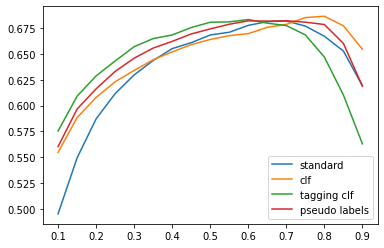

In [307]:
xx = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
plt.plot(xx, scores_standard)
plt.plot(xx, scores_standard_clf)
plt.plot(xx, scores_tagging_clf)
plt.plot(xx, scores_pseudolabel)
plt.legend(['standard', 'clf', 'tagging clf', 'pseudo labels'])

In [315]:
ss = [scores_standard, scores_pseudolabel, scores_standard_clf, scores_tagging_clf]
for sss in ss:
    print(f'{np.max(sss):.3f}, {xx[np.argmax(sss)]}, {sss[8]:.3f}, {sss[10]:.3f}')

0.682, 0.7, 0.668, 0.678
0.682, 0.7, 0.674, 0.682
0.686, 0.8, 0.664, 0.670
0.683, 0.6, 0.681, 0.683


#### standard deviation of score

In [233]:
threshold = 0.5
preds = []
for text, pr in zip(final_test.text, pred.predictions):
    proba = np.exp(pr[pr[:, 0]!=-100])
    proba /= proba.sum(axis=1, keepdims=True)
    labels = (proba[:, 1] >= threshold).astype(int).tolist()
    preds.append(labels2spans(text, labels, tokenizer))
ff = [f1(p, y) for p, y in zip(preds, final_test.spans)]
score = np.mean(ff)
print(score)

0.6682946286098522


In [243]:
se = np.std(ff) / np.sqrt(len(ff)) * 1.96
print(score - se, score + se)

0.6506454922132865 0.685943765006418


In [246]:
np.std(ff) / np.sqrt(len(ff))

0.009004661426819228